# 1. Autoencoder

In [1]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import models
from keras import backend as K
from keras import layers
from keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd


Using TensorFlow backend.


In [45]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [46]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [47]:
from keras.callbacks import TensorBoard
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 63s 1ms/step - loss: 0.2063 - val_loss: 0.1604
Epoch 2/50
60000/60000 [==============================] - 63s 1ms/step - loss: 0.1500 - val_loss: 0.1416
Epoch 3/50
60000/60000 [==============================] - 63s 1ms/step - loss: 0.1366 - val_loss: 0.1324
Epoch 4/50
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1299 - val_loss: 0.1264
Epoch 5/50
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1253 - val_loss: 0.1225
Epoch 6/50
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1224 - val_loss: 0.1215
Epoch 7/50
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1197 - val_loss: 0.1212
Epoch 8/50
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1178 - val_loss: 0.1138
Epoch 9/50
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1165 - val_loss: 0.1129
Epoch

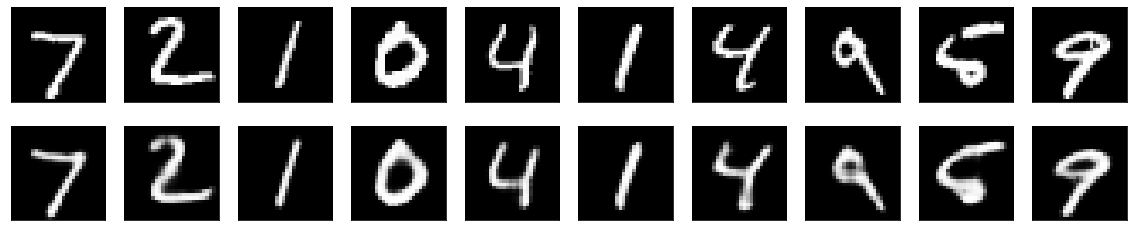

In [49]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 2. Image Classification

## 2.1 Deep CNN

In [33]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#preparing the data for training
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#create sequential
model = models.Sequential()
#add layers
model.add(layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(layers.Conv2D(16, kernel_size=3, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 134s 2ms/step - loss: 0.1618 - accuracy: 0.9567 - val_loss: 0.0699 - val_accuracy: 0.9802
Epoch 2/3
60000/60000 [==============================] - 138s 2ms/step - loss: 0.0584 - accuracy: 0.9824 - val_loss: 0.0674 - val_accuracy: 0.9804
Epoch 3/3
60000/60000 [==============================] - 127s 2ms/step - loss: 0.0444 - accuracy: 0.9861 - val_loss: 0.0709 - val_accuracy: 0.9807


In [38]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 239us/step


[0.07086436897389357, 0.9807000160217285]

## 2.2 Transfer Learning

In [12]:
from keras.datasets import mnist
from keras.preprocessing.image import img_to_array, array_to_img
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#resizing the images to fit min size of resnet
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)
X_train = np.concatenate([X_train]*3, axis = -1)
X_test = np.concatenate([X_test]*3, axis = -1)
X_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32, 32)))for im in X_train])
X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32, 32)))for im in X_test])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape)

(60000, 32, 32, 3)


In [13]:
#calling the resnet model
keras_layer = keras.applications.resnet.ResNet50(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=(32,32,3), pooling=None, classes=10
)
res_Model = models.Sequential()
res_Model.add(keras_layer)
res_Model.add(layers.Flatten())
res_Model.add(layers.Dense(10, activation='softmax'))
res_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
res_Model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 2671s 45ms/step - loss: 0.4268 - accuracy: 0.9130 - val_loss: 0.5374 - val_accuracy: 0.8460
Epoch 2/3
60000/60000 [==============================] - 2657s 44ms/step - loss: 0.2647 - accuracy: 0.9452 - val_loss: 0.0772 - val_accuracy: 0.9760
Epoch 3/3
 1600/60000 [..............................] - ETA: 40:05 - loss: 0.1240 - accuracy: 0.9669

KeyboardInterrupt: 

In [15]:
res_Model.evaluate(X_test, y_test)

10000/10000 [==============================] - 26s 3ms/step


[0.07220974480733275, 0.9782999753952026]

# 3. Text Classification

## 3.1 RNN

In [42]:
df = pd.read_csv('twitter-data/tweets_with_labels.csv', sep='\t')
print(df.head())

   id                                              tweet   k1   k2   k3   k4  \
0   1                Jazz for a Rainy Afternoon:  {link}  0.0  0.0  0.0  0.0   
1   2                   RT: @mention: I love rainy days.  0.0  0.0  0.0  0.0   
2   3  Good Morning Chicago! Time to kick the Windy C...  0.0  0.0  0.0  0.0   
3   6  Preach lol! :) RT @mention: #alliwantis this t...  0.0  0.0  0.0  0.0   
4   9                     @mention good morning sunshine  0.0  0.0  0.0  0.0   

    k5   k6     k7   k8     k9  k10  k11  k12    k13  k14  k15  
0  0.0  0.0  0.000  0.0  0.000  1.0  0.0  0.0  0.000  0.0  0.0  
1  0.0  0.0  0.000  0.0  0.000  1.0  0.0  0.0  0.000  0.0  0.0  
2  0.0  0.0  1.000  0.0  0.000  0.0  0.0  0.0  0.000  0.0  0.0  
3  0.0  0.0  0.604  0.0  0.196  0.0  0.0  0.0  0.201  0.0  0.0  
4  0.0  0.0  0.000  0.0  0.000  0.0  0.0  0.0  1.000  0.0  0.0  


In [43]:
X=df['tweet']
y=df.iloc[:, 2:17]
print(X.head())
print(y.head())

0                  Jazz for a Rainy Afternoon:  {link}
1                     RT: @mention: I love rainy days.
2    Good Morning Chicago! Time to kick the Windy C...
3    Preach lol! :) RT @mention: #alliwantis this t...
4                       @mention good morning sunshine
Name: tweet, dtype: object
    k1   k2   k3   k4   k5   k6     k7   k8     k9  k10  k11  k12    k13  k14  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.000  1.0  0.0  0.0  0.000  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.000  1.0  0.0  0.0  0.000  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  1.000  0.0  0.000  0.0  0.0  0.0  0.000  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.604  0.0  0.196  0.0  0.0  0.0  0.201  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.000  0.0  0.000  0.0  0.0  0.0  1.000  0.0   

   k15  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  


In [44]:
#divid x by space
length = X.size
val =[]
for i in range(length):
    val.append(X[i].split())
X.update(pd.Series(val))
print(X.head())

0            [Jazz, for, a, Rainy, Afternoon:, {link}]
1              [RT:, @mention:, I, love, rainy, days.]
2    [Good, Morning, Chicago!, Time, to, kick, the,...
3    [Preach, lol!, :), RT, @mention:, #alliwantis,...
4                  [@mention, good, morning, sunshine]
Name: tweet, dtype: object


In [ ]:
def det_len(X):
    